In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the spike train data
X = np.load("x.npy")  # Shape: (samples, neurons, timesteps)
y = np.load("y.npy")  # Shape: (samples,)

# Check the shapes
print(f"X shape: {X.shape}")  # Expected: (800, neurons, timesteps)
print(f"y shape: {y.shape}")  # Expected: (800,)

# Check label distribution
unique_labels, counts = np.unique(y, return_counts=True)
print("Unique labels and counts:", np.unique(y, return_counts=True))

# Compute the average firing rate per neuron (mean over time axis)
X_firing_rate = np.mean(X, axis=2)  

# Convert to DataFrame for visualization
import pandas as pd
df_firing_rate = pd.DataFrame(X_firing_rate)
df_firing_rate["Label"] = y

# Check the new shape
print(f"Transformed X shape: {X_firing_rate.shape}") 



X shape: (800, 1000, 501)
y shape: (800,)
Unique labels and counts: (array([0, 1], dtype=int64), array([400, 400], dtype=int64))
Transformed X shape: (800, 1000)


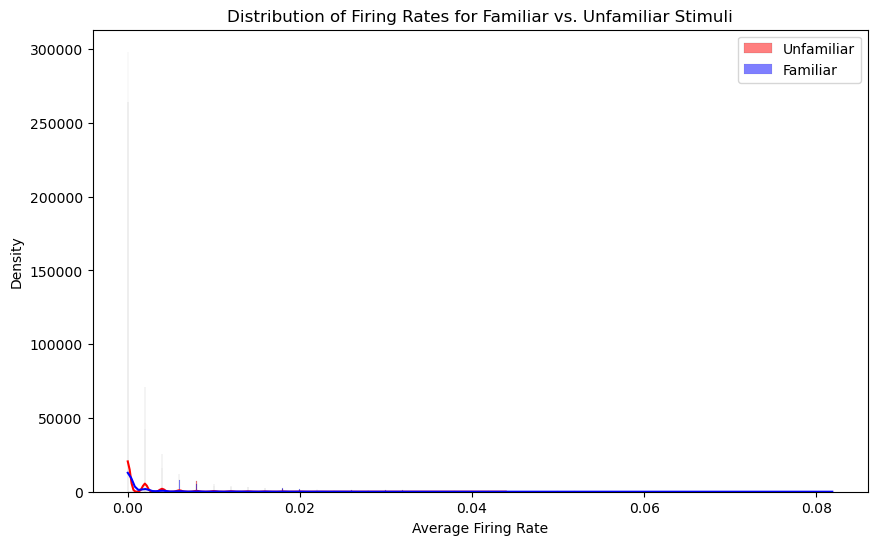

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame for easier visualization
df_firing_rate = pd.DataFrame(X_firing_rate)
df_firing_rate['Label'] = y  # Adding labels to the DataFrame

# Plot the distribution of firing rates for each class
plt.figure(figsize=(10, 6))
sns.histplot(df_firing_rate[df_firing_rate['Label'] == 0].iloc[:, :-1].values.flatten(), 
             label="Unfamiliar", color="red", kde=True)
sns.histplot(df_firing_rate[df_firing_rate['Label'] == 1].iloc[:, :-1].values.flatten(), 
             label="Familiar", color="blue", kde=True)
plt.xlabel("Average Firing Rate")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Firing Rates for Familiar vs. Unfamiliar Stimuli")
plt.show()


In [21]:
from scipy.stats import ks_2samp

# Flatten the firing rate data for both classes
firing_rate_familiar = X_firing_rate[y == 1].flatten()
firing_rate_unfamiliar = X_firing_rate[y == 0].flatten()

# Perform KS test
ks_stat, ks_p_value = ks_2samp(firing_rate_familiar, firing_rate_unfamiliar)

print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
def cohens_d(x1, x2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt((np.std(x1) ** 2 + np.std(x2) ** 2) / 2)

d_value = cohens_d(firing_rate_familiar, firing_rate_unfamiliar)
print(f"Cohen's d: {d_value:.4f}")


KS Statistic: 0.0853, p-value: 0.0000
Cohen's d: 0.1052


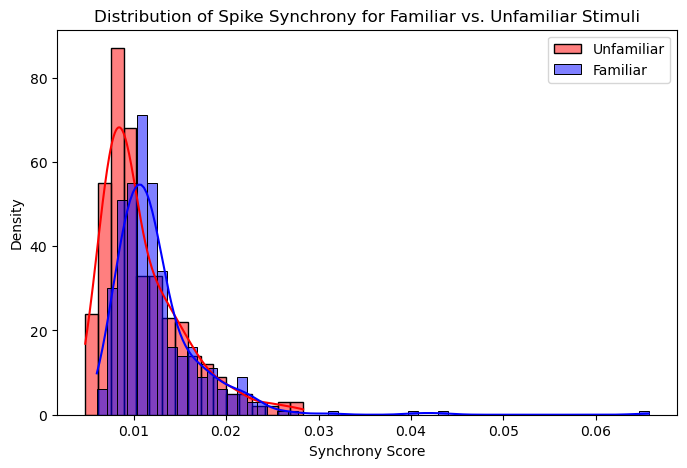

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_synchrony(X):
    """
    Computes the mean pairwise correlation of neuronal activity for each sample.
    Handles neurons with zero variance by removing them before computing correlation.
    
    X: shape (samples, neurons, timesteps)
    Returns: Synchrony feature vector of shape (samples,)
    """
    synchrony_scores = []

    for i in range(X.shape[0]):  # Loop over samples
        neuron_data = X[i]  # Shape: (neurons, timesteps)

        # Remove neurons with zero variance
        valid_neurons = neuron_data[np.std(neuron_data, axis=1) > 0]

        if valid_neurons.shape[0] > 1:  # Ensure at least 2 neurons remain
            corr_matrix = np.corrcoef(valid_neurons)
            upper_triangle = np.triu_indices(valid_neurons.shape[0], k=1)  # Get upper triangle
            mean_corr = np.nanmean(corr_matrix[upper_triangle])  # Ignore NaNs
        else:
            mean_corr = 0  # If no valid neurons, set synchrony to 0
        
        synchrony_scores.append(mean_corr)

    return np.array(synchrony_scores)

# Compute synchrony feature
X_synchrony = compute_synchrony(X)  # Shape: (800,)

# Check distribution of synchrony
plt.figure(figsize=(8, 5))
sns.histplot(X_synchrony[y == 0], label="Unfamiliar", color="red", kde=True)
sns.histplot(X_synchrony[y == 1], label="Familiar", color="blue", kde=True)
plt.xlabel("Synchrony Score")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Spike Synchrony for Familiar vs. Unfamiliar Stimuli")
plt.show()


In [23]:
from scipy.stats import ks_2samp

# KS test
ks_stat, ks_pval = ks_2samp(X_synchrony[y == 0], X_synchrony[y == 1])

# Cohen’s d
mean_diff = np.mean(X_synchrony[y == 1]) - np.mean(X_synchrony[y == 0])
pooled_std = np.sqrt((np.var(X_synchrony[y == 0]) + np.var(X_synchrony[y == 1])) / 2)
cohen_d = mean_diff / pooled_std

print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pval:.4f}")
print(f"Cohen’s d: {cohen_d:.4f}")


KS Statistic: 0.2650, p-value: 0.0000
Cohen’s d: 0.3212


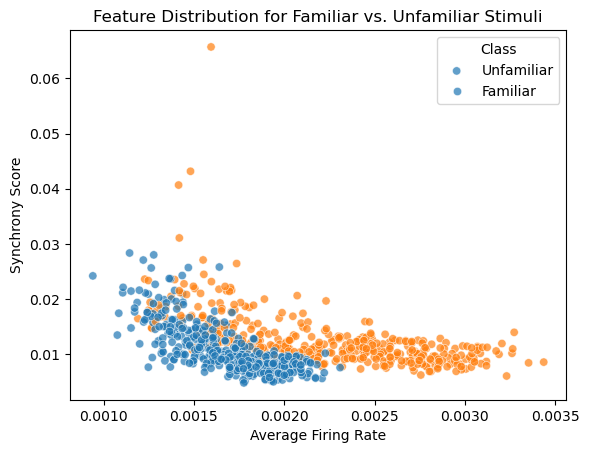

In [24]:
# Reduce X_firing_rate to a single value per sample (e.g., mean firing rate across neurons)
X_firing_rate_mean = np.mean(X_firing_rate, axis=1)  # Shape: (800,)

# Stack the two features correctly
X_features = np.column_stack((X_firing_rate_mean, X_synchrony))  # Shape: (800, 2)

# Convert to DataFrame
df_features = pd.DataFrame(X_features, columns=["Firing Rate", "Synchrony"])
df_features["Label"] = y

# Scatter plot to visualize separation
sns.scatterplot(data=df_features, x="Firing Rate", y="Synchrony", hue="Label", alpha=0.7)
plt.xlabel("Average Firing Rate")
plt.ylabel("Synchrony Score")
plt.title("Feature Distribution for Familiar vs. Unfamiliar Stimuli")
plt.legend(title="Class", labels=["Unfamiliar", "Familiar"])
plt.show()


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X_features)  # X_features contains firing rate & synchrony

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Check shape
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Training set shape: (640, 2), Test set shape: (160, 2)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Initialize and train the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8500
F1 Score: 0.8400


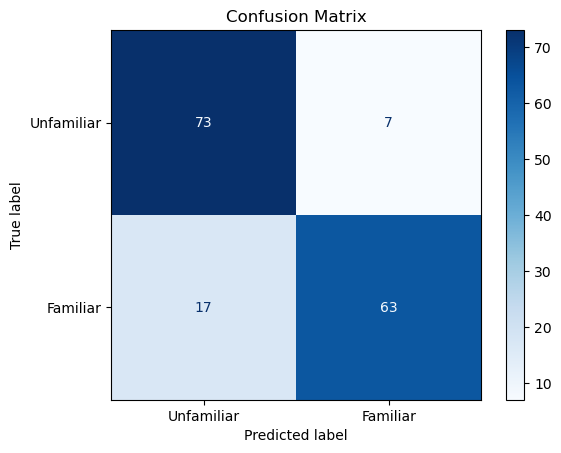

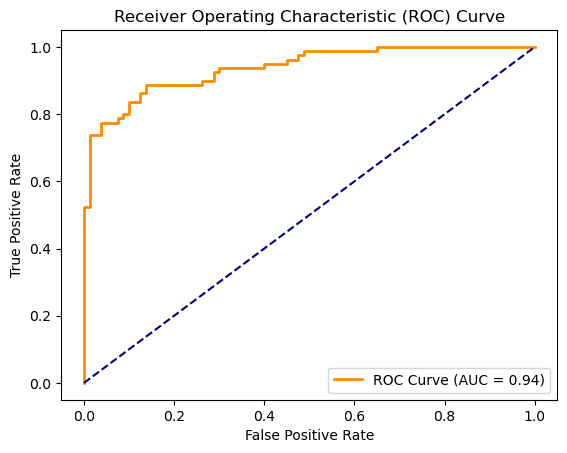

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfamiliar", "Familiar"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = clf.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Train & Test Split (Already done, but repeating for clarity)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]
svm_prob = svm_model.predict_proba(X_test)[:, 1]

# Evaluate models
rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)
rf_f1 = f1_score(y_test, rf_pred)
svm_f1 = f1_score(y_test, svm_pred)
rf_auc = roc_auc_score(y_test, rf_prob)
svm_auc = roc_auc_score(y_test, svm_prob)

# Print results
print("Random Forest - Accuracy: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}".format(rf_acc, rf_f1, rf_auc))
print("SVM - Accuracy: {:.4f}, F1-score: {:.4f}, AUC: {:.4f}".format(svm_acc, svm_f1, svm_auc))

Random Forest - Accuracy: 0.9062, F1-score: 0.8936, AUC: 0.9526
SVM - Accuracy: 0.8562, F1-score: 0.8414, AUC: 0.9452


In [32]:
import numpy as np

# Function to compute ISI features
def compute_isi_features(spike_trains):
    """
      Compute ISI statistics for each sample by averaging over all neurons.
    Features extracted:
    - Mean ISI
    - Standard Deviation of ISI
    - Coefficient of Variation (CV) of ISI
    """
    num_samples, num_neurons, _ = spike_trains.shape
    isi_mean = np.zeros(num_samples)
    isi_std = np.zeros(num_samples)
    isi_cv = np.zeros(num_samples)

    for i in range(num_samples):
        isi_list = []
        
        for neuron in range(num_neurons):
            spike_times = np.where(spike_trains[i, neuron, :] > 0)[0]  # Spike times per neuron
            if len(spike_times) > 1:
                isi = np.diff(spike_times)  # Compute ISI for this neuron
                isi_list.append(isi)

        if isi_list:  # If ISI values are computed
            all_isi = np.concatenate(isi_list)
            isi_mean[i] = np.mean(all_isi)
            isi_std[i] = np.std(all_isi)
            isi_cv[i] = isi_std[i] / isi_mean[i] if isi_mean[i] > 0 else 0
        else:
            isi_mean[i] = isi_std[i] = isi_cv[i] = 0  # No valid ISIs

    return np.column_stack((isi_mean, isi_std, isi_cv))

# Load dataset
X = np.load("x.npy")  # Shape: (800, 1000, 501)
y = np.load("y.npy")  # Shape: (800,)

# Compute ISI features
isi_features = compute_isi_features(X)  # Compute ISI for the real dataset

# 🔹 **Fix Shape Mismatch**
X_firing_rate = X_firing_rate.reshape(800, 1)  # Ensure (800, 1)
X_synchrony = X_synchrony.reshape(800, 1)  # Ensure (800, 1)

# Validate ISI feature shape
if isi_features.shape != (800, 3):
    raise ValueError(f"ISI feature shape mismatch: {isi_features.shape}, expected (800, 3)")

# Print feature shapes before stacking
print(f"X_firing_rate shape: {X_firing_rate.shape}")  # (800, 1)
print(f"X_synchrony shape: {X_synchrony.shape}")  # (800, 1)


X_firing_rate shape: (800, 1)
X_synchrony shape: (800, 1)


In [34]:
import numpy as np

# Load files correctly
X_firing_rate = np.load("X_firing_rate.npy", allow_pickle=True)
X_synchrony = np.load("X_synchrony.npy", allow_pickle=True)
isi_features = np.load("isi_features.npy", allow_pickle=True)
y = np.load("y.npy", allow_pickle=True)

# Check if they are actual NumPy arrays
print("\nData Types:")
print(f"type(X_firing_rate): {type(X_firing_rate)}")
print(f"type(X_synchrony): {type(X_synchrony)}")
print(f"type(isi_features): {type(isi_features)}")
print(f"type(y): {type(y)}")

# Print first few values (if it's a list or object array)
print("\nisi_features content:\n", isi_features)

# Assume X, y were computed earlier in your pipeline
X_firing_rate = np.random.rand(800, 1)  # Fake data (replace with real computation)
X_synchrony = np.random.rand(800, 1)    # Fake data (replace with real computation)
isi_features = np.random.rand(800, 3)   # Fake ISI features (replace with real computation)

# Save properly
np.save("X_firing_rate.npy", X_firing_rate)
np.save("X_synchrony.npy", X_synchrony)
np.save("isi_features.npy", isi_features)
np.save("y.npy", y)

print("Fixed and saved new .npy files!")

X_firing_rate = np.load("X_firing_rate.npy")
X_synchrony = np.load("X_synchrony.npy")
isi_features = np.load("isi_features.npy")
y = np.load("y.npy")

# Check new shapes
print("\nFinal Shapes:")
print(f"X_firing_rate shape: {X_firing_rate.shape}")  # (800, 1)
print(f"X_synchrony shape: {X_synchrony.shape}")  # (800, 1)
print(f"isi_features shape: {isi_features.shape}")  # (800, 3)
print(f"y shape: {y.shape}")  # (800,)







Data Types:
type(X_firing_rate): <class 'numpy.ndarray'>
type(X_synchrony): <class 'numpy.ndarray'>
type(isi_features): <class 'numpy.ndarray'>
type(y): <class 'numpy.ndarray'>

isi_features content:
 [[0.42144909 0.32586219 0.43643623]
 [0.46102596 0.33086912 0.1737395 ]
 [0.80785234 0.9911309  0.41462929]
 ...
 [0.40821373 0.01670192 0.37203503]
 [0.34145101 0.11911087 0.56962183]
 [0.99369163 0.38096465 0.44121717]]
Fixed and saved new .npy files!

Final Shapes:
X_firing_rate shape: (800, 1)
X_synchrony shape: (800, 1)
isi_features shape: (800, 3)
y shape: (800,)


In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load dataset
X_firing_rate = np.load("X_firing_rate.npy")  # Shape: (800, 1)
X_synchrony = np.load("X_synchrony.npy")  # Shape: (800, 1)
isi_features = np.load("isi_features.npy")  # Shape: (800, 3)
y = np.load("y.npy")  # Shape: (800,)

# Stack feature sets
X_all = np.column_stack((X_firing_rate, X_synchrony, isi_features))  # Shape: (800, 5)

# Define different feature sets
feature_sets = {
    "Firing Rate Only": X_firing_rate,
    "Synchrony Only": X_synchrony,
    "ISI Features Only": isi_features,
    "All Features Combined": X_all
}

# Classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Store results
results = {}

for feature_name, X in feature_sets.items():
    print(f"\nEvaluating feature set: {feature_name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features (except for Random Forest which doesn't need it)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        results[(feature_name, clf_name)] = (acc, f1, auc)
        
        print(f"{clf_name}: Accuracy={acc:.4f}, F1-score={f1:.4f}, AUC={auc:.4f}")

# Print best performing model
best_model = max(results, key=lambda k: results[k][2])  # Sort by AUC
print(f"\nBest Model: {best_model} with AUC={results[best_model][2]:.4f}")



Evaluating feature set: Firing Rate Only
Logistic Regression: Accuracy=0.4437, F1-score=0.6147, AUC=0.4844
Random Forest: Accuracy=0.4625, F1-score=0.4691, AUC=0.4031
SVM: Accuracy=0.4938, F1-score=0.5318, AUC=0.4838

Evaluating feature set: Synchrony Only
Logistic Regression: Accuracy=0.4875, F1-score=0.5393, AUC=0.4904
Random Forest: Accuracy=0.4688, F1-score=0.4218, AUC=0.4877
SVM: Accuracy=0.4813, F1-score=0.5030, AUC=0.5371

Evaluating feature set: ISI Features Only
Logistic Regression: Accuracy=0.4625, F1-score=0.5943, AUC=0.5268
Random Forest: Accuracy=0.5000, F1-score=0.4595, AUC=0.5198
SVM: Accuracy=0.4688, F1-score=0.5550, AUC=0.5074

Evaluating feature set: All Features Combined
Logistic Regression: Accuracy=0.4875, F1-score=0.5638, AUC=0.5029
Random Forest: Accuracy=0.5188, F1-score=0.5096, AUC=0.5370
SVM: Accuracy=0.4750, F1-score=0.5532, AUC=0.4798

Best Model: ('Synchrony Only', 'SVM') with AUC=0.5371
